# Ultimate Technologies Take Home

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pathlib

In [2]:
cwd = pathlib.Path.cwd()

## Part 1:

Time Series EDA on the logins.json data.

In [17]:
df_loggins = pd.read_json(cwd/'data/logins.json')

In [18]:
df_loggins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [19]:
df_loggins.describe()

<ipython-input-19-5dca6ad134cf>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_loggins.describe()


,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [20]:
df_loggins.isna().sum()

login_time    0
dtype: int64

    There are no missing dates in the series. We will now be doing analysis on the series when it is aggregated at the qtr hr level.

In [21]:
df_loggins['is_loggin'] = 1 
# adding a column of ones to allow aggregation

In [22]:
df_loggins_15min = df_loggins.groupby(pd.Grouper(key='login_time', freq='15min'))['is_loggin'].agg('count')

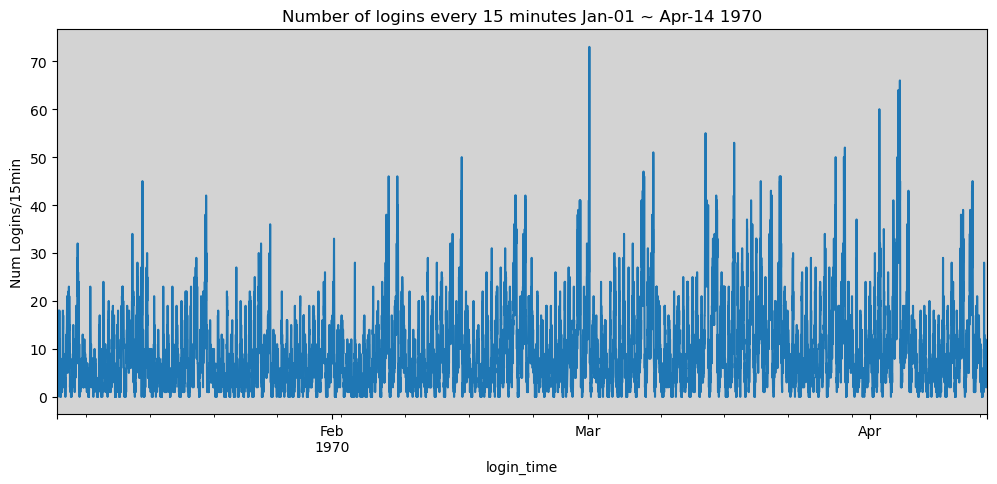

In [23]:
_, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_facecolor('lightgray')

df_loggins_15min.plot(ax=ax)
ax.set_title('Number of logins every 15 minutes Jan-01 ~ Apr-14 1970')
ax.set_ylabel('Num Logins/15min')

plt.show()

    From the above figure we can see that there is some clear evidence of a seasonal pattern. There are multiple frequencies that can possible detected here:
        - Weekly
        - Daily
        - Hourly?

    We shall do some closer invesitgation of the data through decomposition to see overall trends in the data as well as to better understand patterns on a daily level.

In [10]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

In [24]:
loggins_decomposed = STL(df_loggins_15min.values, period=24*4*7).fit()

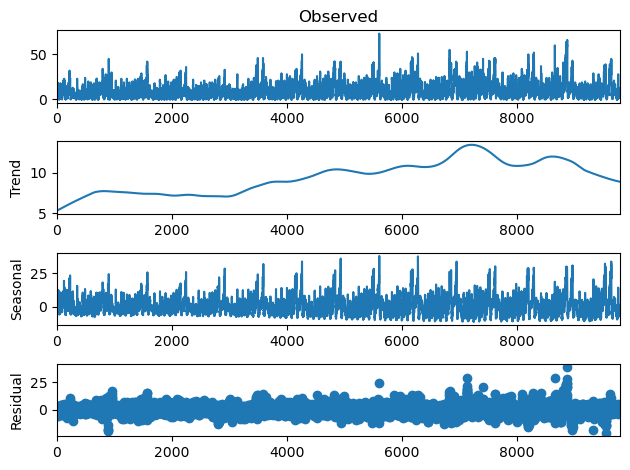

In [25]:
loggins_decomposed.plot()

    Looking at the decomposed series above that on a weekly level there appears to be an increase in trend that starts around the beginning of February and peaks in late March.
    
    How would the monthly aggregation of trends look like over a year?

In [26]:
df_loggins_15min = df_loggins_15min.reset_index()
df_loggins_15min['7day_rolling_mean'] = df_loggins_15min.rolling(24*4*7).mean()

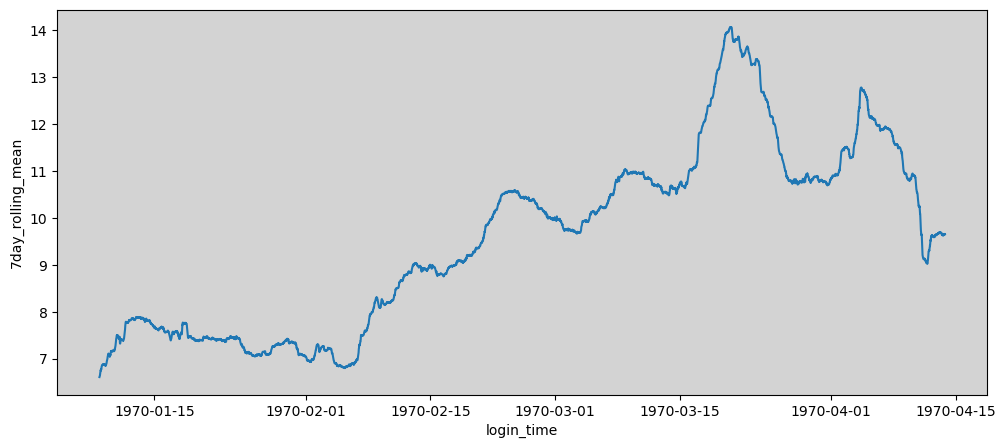

In [28]:
_, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_facecolor('lightgray')

sns.lineplot(data=df_loggins_15min.dropna(axis=0), x='login_time', y='7day_rolling_mean', ax=ax)

plt.show()

    A rolling average of the data over a 1-week window shows that indeed there is an increase in demand that begins in February that peaks in the last week of March before dropping.

In [29]:
import datetime as dt

In [30]:
df_loggins_15min['date'] = df_loggins_15min.login_time.dt.date
df_loggins_15min['time'] = df_loggins_15min.login_time.dt.time

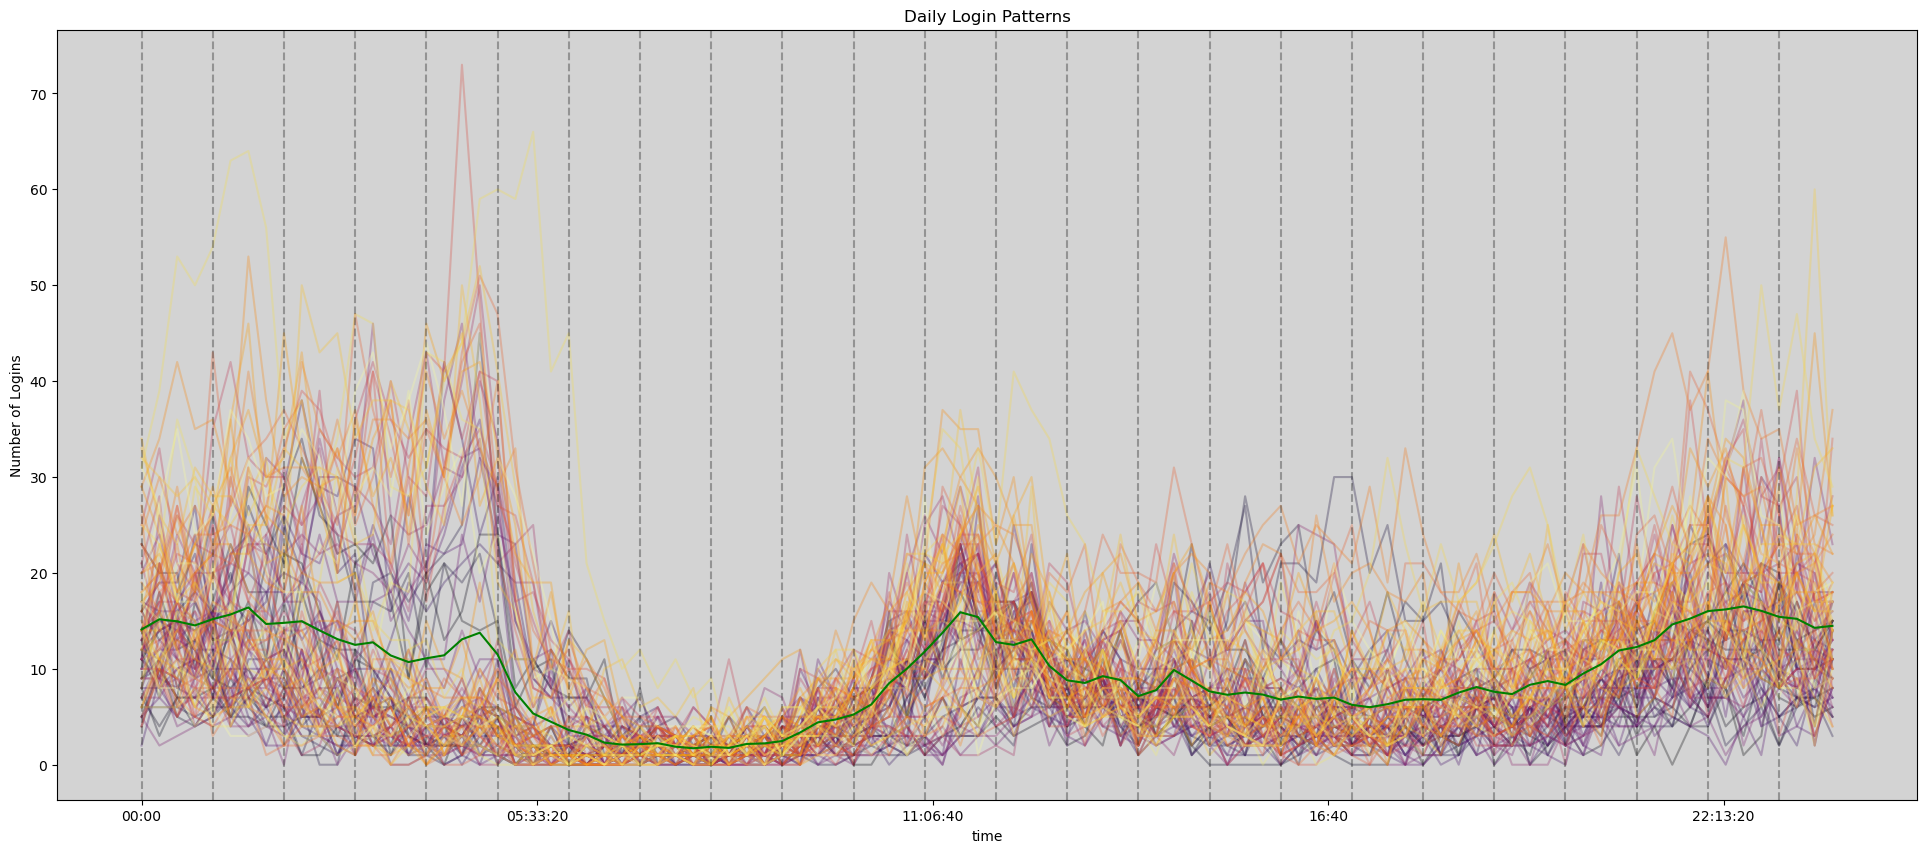

In [31]:
colors = [cm.inferno(i) for i in np.linspace(0,1, len(df_loggins_15min.date.unique()))]

_, ax = plt.subplots(1,1,figsize=(24,10))
ax.set_facecolor('lightgray')

for clr, day in zip(colors, df_loggins_15min.date.unique()):
    tmp = df_loggins_15min[df_loggins_15min.date == day].reset_index(drop=True)

    ax.plot(tmp.time, tmp.is_loggin, color=clr, label=day, alpha=0.3)
ax.set_title('Daily Login Patterns')
ax.set_ylabel('Number of Logins')
for i in range(24):
    if i < 10:
        str_val = f'0{i}:00:00'
    else:
        str_val = f'{i}:00:00'
    ax.axvline(str_val, color='black', linestyle='--', alpha=0.3)
df_loggins_15min.groupby('time')['is_loggin'].mean().plot(ax=ax, color='green')
#plt.legend(loc='upper left', bbox_to_anchor=(1.0,.95))

plt.show()

    Through subsetting the data by date and plotting the number of logins for each time window for each day reveals interesting patterns in demand.
    
    Demand each day appears to carry over from the previous day, with high variation in the qtrhr demand lasting from 0-5 am after which there is a consistent drop off. 
    
    The lowest period of demand is roughly between 6 and 10 am every day with the average demand during this period being roughly 1. There is a peak around lunch time that slowly tappers off to around 5 request every 15 minutes that lasts until 8 pm when there is another increase in demand.